# Examples from Chapter 2

### Remark 2.30

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.spatial.distance import cdist

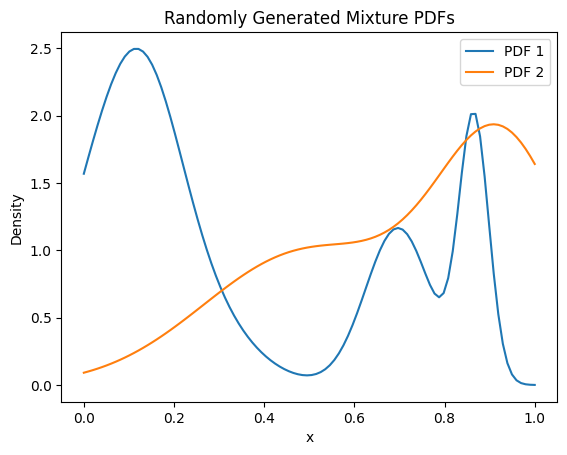

In [2]:
num_points=100

def generate_random_mixture_pdf(num_components=5, num_points=num_points):
    # Generate random means and variances for the Gaussian components
    means = np.random.rand(num_components)
    variances = np.random.rand(num_components) * 0.05  # Small variances to keep them within [0, 1]
    weights = np.random.rand(num_components)
    weights /= np.sum(weights)  # Normalize weights to sum to 1

    # Create a fine grid over [0, 1]
    x = np.linspace(0, 1, num_points)

    # Evaluate the mixture of Gaussians
    y = np.zeros(num_points)
    for mean, var, weight in zip(means, variances, weights):
        y += weight * norm.pdf(x, loc=mean, scale=np.sqrt(var))

    # Normalize the mixture to make it a valid PDF
    y /= np.trapz(y, x)

    return x, y

# Generate two random mixture PDFs
x1, pdf1 = generate_random_mixture_pdf()
x2, pdf2 = generate_random_mixture_pdf()

# Plot the PDFs
plt.plot(x1, pdf1, label='PDF 1')
plt.plot(x2, pdf2, label='PDF 2')
plt.legend()
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Randomly Generated Mixture PDFs')
plt.show()

In [3]:
p = 2

C = cdist(x1[:, np.newaxis], x2[:, np.newaxis])

C = np.power(C, p)

In [4]:
a = pdf1 / np.sum(pdf1)
b = pdf2 / np.sum(pdf2)

Now build CDFs:

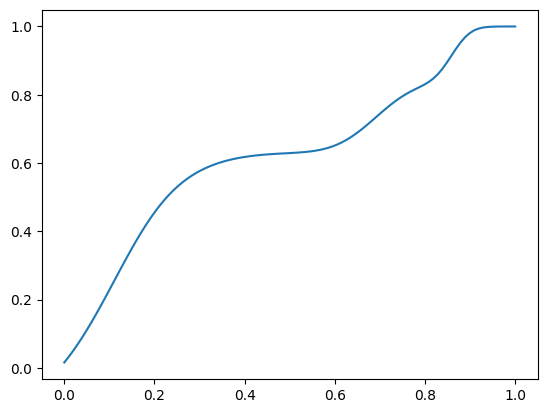

In [5]:
a_CDF = np.cumsum(a)
plt.plot(x1, a_CDF, label='CDF a')

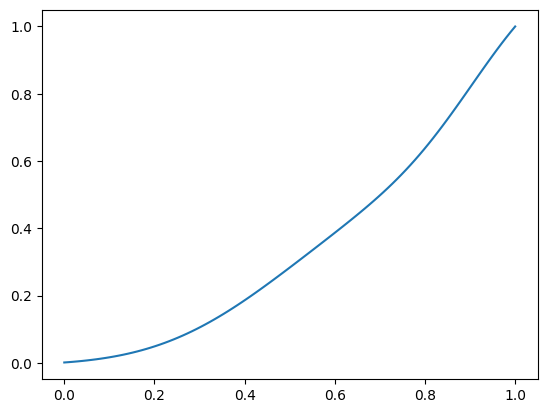

In [6]:
b_CDF = np.cumsum(b)
plt.plot(x1, b_CDF, label='CDF b')

In [7]:
quantiles = np.linspace(0, 1, num_points)

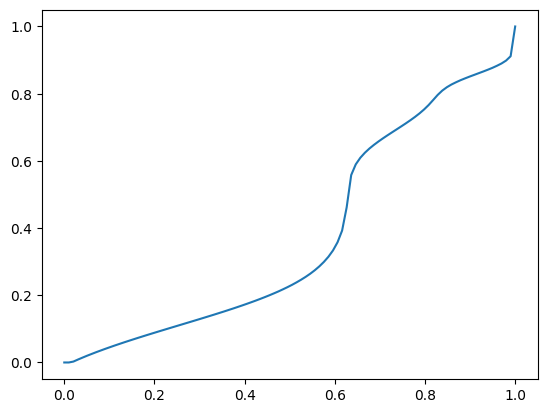

In [8]:
a_CDF_inv = np.interp(quantiles, a_CDF, x1)
plt.plot(x1, a_CDF_inv, label='inverse CDF a')

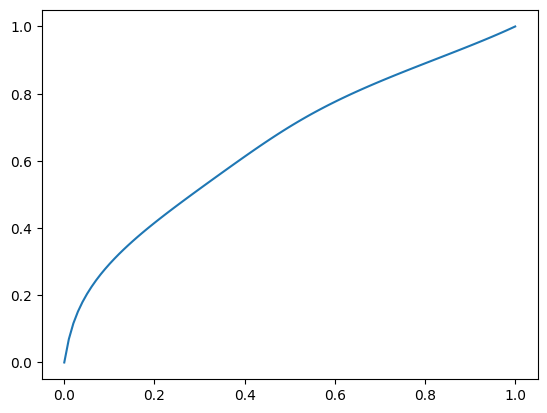

In [9]:
b_CDF_inv = np.interp(quantiles, b_CDF, x1)
plt.plot(x1, b_CDF_inv, label='inverse CDF b')

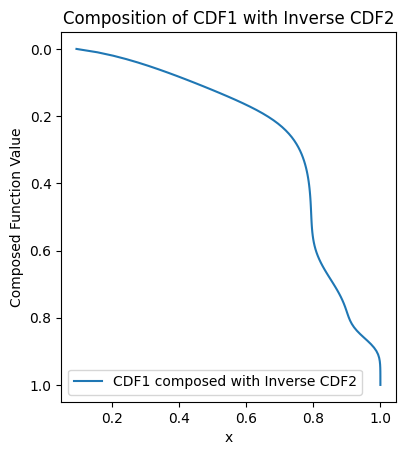

In [10]:
# Compose CDF a with inverse CDF b
x = np.linspace(0, 1, num_points)
a_CDF_vals = np.interp(x, x1, a_CDF)

composed_function = np.interp(a_CDF_vals, quantiles, b_CDF_inv)

# Plot the composed function
plt.plot(composed_function, x, label='CDF1 composed with Inverse CDF2')
plt.xlabel('x')
plt.ylabel('Composed Function Value')
plt.title('Composition of CDF1 with Inverse CDF2')
plt.gca().set_aspect('equal', adjustable='box') # set aspect ratio to equal
plt.gca().invert_yaxis() # flip y-axis to be consistent with heatmap plotting below
plt.legend()
plt.show()

Final Transport Cost: 0.09651707986029642


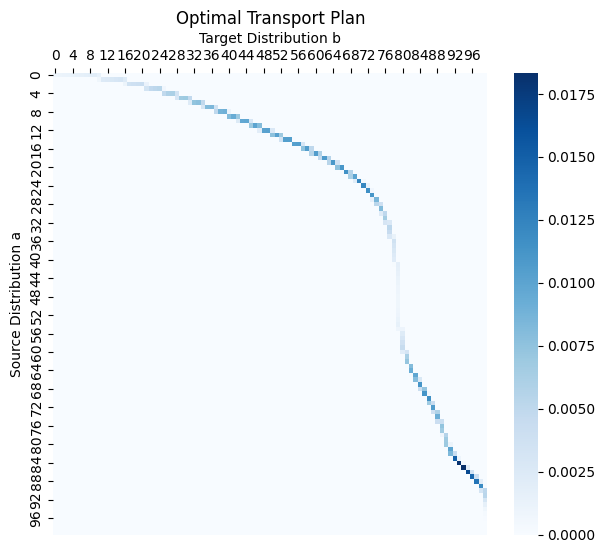

In [11]:
from scipy.optimize import linprog

# Flatten the cost matrix for the objective function
c = C.flatten()

# Equality constraints matrix A_eq and vector b_eq
# Constraints to ensure the sum of transported mass equals the probability vectors
A_eq = []
b_eq = []

# Supply constraints
for i in range(len(a)):
    constraint = np.zeros(C.shape)
    constraint[i, :] = 1
    A_eq.append(constraint.flatten())
    b_eq.append(a[i])

# Demand constraints
for j in range(len(b)):
    constraint = np.zeros(C.shape)
    constraint[:, j] = 1
    A_eq.append(constraint.flatten())
    b_eq.append(b[j])

A_eq = np.array(A_eq)
b_eq = np.array(b_eq)

# Bounds for each variable (all should be non-negative)
x_bounds = [(0, None) for _ in range(len(c))]

# Solve the linear programming problem
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=x_bounds, method='highs')

# Display the result
if result.success:
    optimal_transport_plan = result.x.reshape(C.shape)
    # print("Optimal Transport Plan:")
    # print(optimal_transport_plan)
    final_cost = np.sum(optimal_transport_plan * C)
    print("Final Transport Cost:", final_cost)
    plt.figure(figsize=(7, 6))
    ax = sns.heatmap(optimal_transport_plan, annot=False, cmap='Blues')
    #current_xticks = ax.get_xticks()
    #current_yticks = ax.get_yticks()
    #new_xticks = [f'{b[int(tick)]:.3f}' for tick in current_xticks]
    #new_yticks = [f'{a[int(tick)]:.3f}' for tick in current_yticks]
    #ax.set_xticklabels(new_xticks)
    #ax.set_yticklabels(new_yticks)
    plt.title("Optimal Transport Plan")
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    plt.xlabel("Target Distribution b")
    plt.ylabel("Source Distribution a")
    plt.show()
else:
    print("Optimization failed:", result.message)